In [5]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *

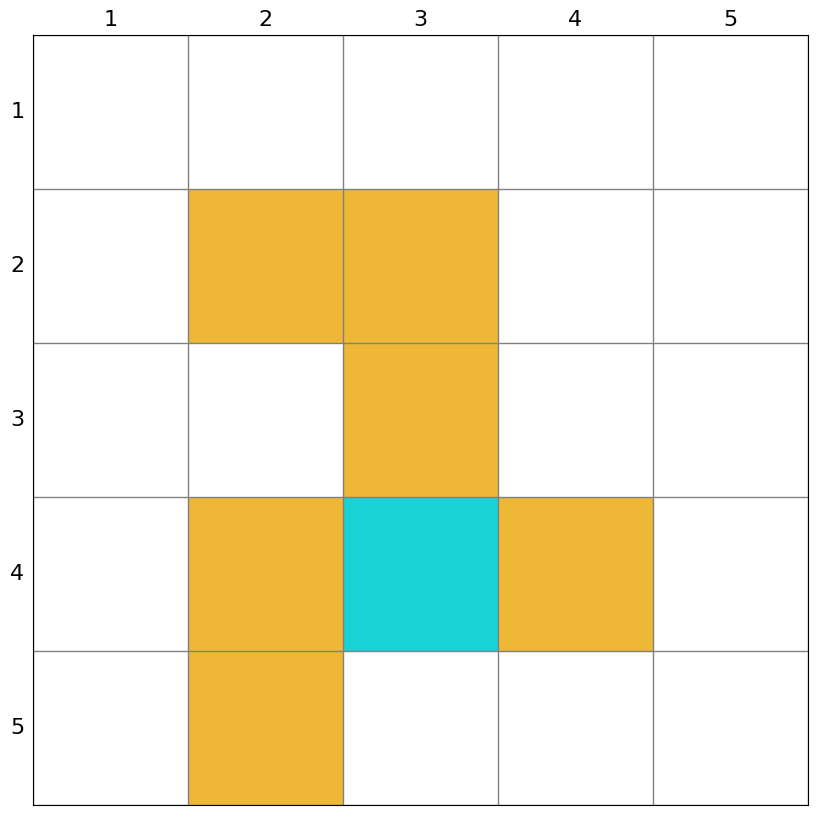

In [6]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [7]:
def truncated_iteration(env, theta = 0.0001, gamma = 0.8, steps=100 , truncated = 5):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    reward_list = env.reward_list
    reward_space_size = len(reward_list)
    
    state_value_k = np.zeros(shape=(state_space_size))  # 初始化状态值函数为全零的数组，形状为 (state_space_size)，记录每个状态的值。
    policy = np.ones(shape=(state_space_size, action_space_size)) / action_space_size  # 初始化策略为均匀分布
    for step in range (steps):
        for _ in range(truncated):
            state_value_k_new = np.copy(state_value_k)  # 创建新的状态值来更新
            for state in range(state_space_size):
                state_value_new = 0
                for action in range(action_space_size):
                    action_value = 0
                    for i in range(reward_space_size):
                        action_value += env.Rsa[state, action, i] * reward_list[i]
                    
                    for next_state in range(state_space_size):
                        action_value += gamma * env.Psa[state, action, next_state] * state_value_k[next_state]                    
                    state_value_new += policy[state, action] * action_value

                state_value_k[state] = state_value_new
            state_value_k = state_value_k_new  # 更新状态值函数
            
        policy_stable = True  # 假设策略稳定
        for state in range(state_space_size):
            qvalue_list = []
            for action in range(action_space_size):
                qvalue = 0
                for i in range(reward_space_size):
                    qvalue += env.Rsa[state, action, i] * reward_list[i]
                for next_state in range(state_space_size):
                    qvalue += gamma * env.Psa[state, action, next_state] * state_value_k[next_state]
                    
                qvalue_list.append(qvalue)
            best_action = np.argmax(qvalue_list)
            
            # 更新策略
            new_policy = np.eye(action_space_size)[best_action]#np.eye(action_space_size) 会生成一个大小为 action_space_size 的单位矩阵（identity matrix）。
            if not np.array_equal(policy[state], new_policy):
                policy_stable = False
            policy[state] = new_policy
        
        # 如果策略稳定，则停止
        if policy_stable:
            print(f"Policy converged after {step + 1} steps.")
            break
        
    return policy, state_value_k

In [ ]:
def truncated_policy_iteration(env, theta=0.0001, gamma=0.8, steps=100, truncated=5):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    reward_list = env.reward_list
    reward_space_size = len(reward_list)

    state_value_k = np.zeros(shape=(state_space_size))  # 初始化状态值函数为全零的数组
    policy = np.ones(shape=(state_space_size, action_space_size)) / action_space_size  # 初始化策略为均匀分布

    for step in range(steps):
        # 1. 策略评估 (截断到指定次数)
        for _ in range(truncated):
            state_value_k_new = np.copy(state_value_k)  # 创建新的状态值来更新
            for state in range(state_space_size):
                state_value_new = 0
                for action in range(action_space_size):
                    action_value = 0
                    for i in range(reward_space_size):
                        action_value += env.Rsa[state, action, i] * reward_list[i]
                    
                    for next_state in range(state_space_size):
                        action_value += gamma * env.Psa[state, action, next_state] * state_value_k[next_state]
                    
                    state_value_new += policy[state, action] * action_value
                
                state_value_k_new[state] = state_value_new

            state_value_k = state_value_k_new  # 更新状态值函数

        # 2. 策略改进
        policy_stable = True  # 假设策略稳定
        for state in range(state_space_size):
            qvalue_list = []
            for action in range(action_space_size):
                qvalue = 0
                for i in range(reward_space_size):
                    qvalue += env.Rsa[state, action, i] * reward_list[i]
                
                for next_state in range(state_space_size):
                    qvalue += gamma * env.Psa[state, action, next_state] * state_value_k[next_state]
                
                qvalue_list.append(qvalue)

            # 选择最优动作
            best_action = np.argmax(qvalue_list)
            
            # 更新策略
            new_policy = np.eye(action_space_size)[best_action]
            if not np.array_equal(policy[state], new_policy):
                policy_stable = False
            policy[state] = new_policy
        
        # 如果策略稳定，则停止
        if policy_stable:
            print(f"Policy converged after {step + 1} steps.")
            break

    return policy, state_value_k

In [8]:
policy , state_value_k = truncated_policy_iteration(env,truncated=20)
print(policy , state_value_k)

Policy converged after 9 steps.
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] [0.53687091 0.42949673 0.34359738 0.27487791 0.21990233 0.67108864
 0.53687091 0.27487791 5.         4.         0.8388608  1.048576
 5.         5.         5.         1.048576   1.31072    1.6384
 5.         4.         1.31072    1.6384     2.048      2.56
 3.2       ]
